#Trabajo Práctico N°2. Ejercicio N°3b. Potenciales evocados. 

---
## Alumnas
- Brisa Rojas (60535)
- Camila Sobrino (61585)

#Configuraciones iniciales 
----

##Drive
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Librerias
---


In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import sosfiltfilt, butter, find_peaks
import numpy as np
import pandas as pd
import csv
import scipy.signal as sig
import seaborn as sns

import scipy.io
import matplotlib.pyplot as plt 
import numpy as np
import scipy.signal as sig
import matplotlib as mpl
import scipy.linalg as sl
import scipy as sp
from scipy.fftpack import fft, ifft, fftfreq
from scipy.linalg import toeplitz

#Desarrollo del TP
----

#Punto N°1:
----

##Adquisición de las señales 
---

Lo primero que se hace es guardar las señales que se analizaran en un diccionario para cada registro. Los canales que se van a analizar son los siguientes:

* Canal 1: Fz
* Canal 3: Oz
* Canal 5: EOG izquierdo
* Canal 7: EOG derecho

In [ ]:
dic_A1={}
dic_A2={}
dic_F1={}
dic_F2={}

def guardar_canales(diccionario,ruta):
  x = pd.read_csv(ruta,sep='\t')
  diccionario['Fz']=np.ravel(x[x.columns[1]])
  diccionario['Oz']=np.ravel(x[x.columns[3]])
  diccionario['EOGi']=np.ravel(x[x.columns[5]])
  diccionario['EOGd']=np.ravel(x[x.columns[7]])

guardar_canales(dic_A1,'/content/drive/MyDrive/Ejercicio 3/A1.csv')
guardar_canales(dic_A2,'/content/drive/MyDrive/Ejercicio 3/A2.csv')
guardar_canales(dic_F1,'/content/drive/MyDrive/Ejercicio 3/F1.csv')
guardar_canales(dic_F2,'/content/drive/MyDrive/Ejercicio 3/F2.csv')

A continuación se grafican las señales de todos los canales para cada uno de los registros. 

In [ ]:
def graficar_canales(diccionario,titulo):
  claves=list(diccionario.keys())
  t=np.linspace(0,len(diccionario[claves[0]])/250,len(diccionario[claves[0]]))
  
  for i in range(len(claves)):
    plt.figure(figsize=(25,5))
    plt.plot(diccionario[claves[i]],label=claves[i])
    plt.title(titulo)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud [uS]')
    plt.show()
  
  print("\n")

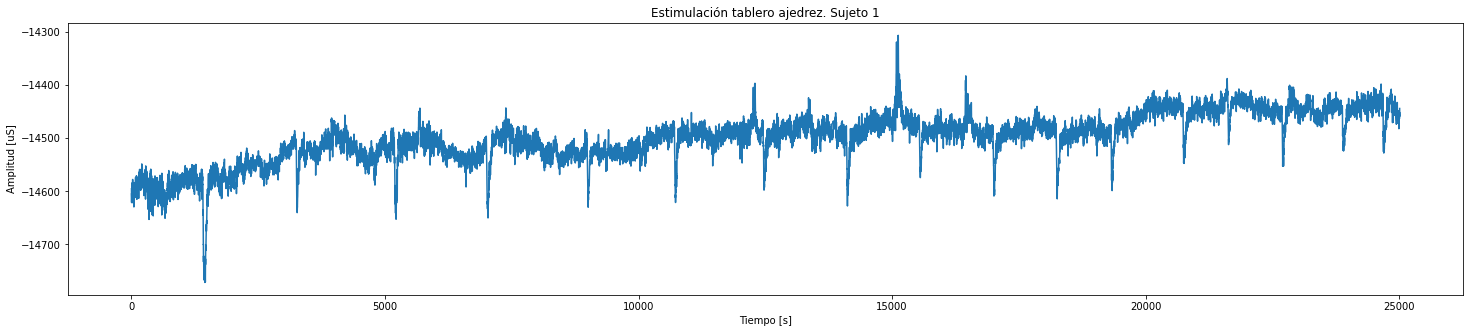

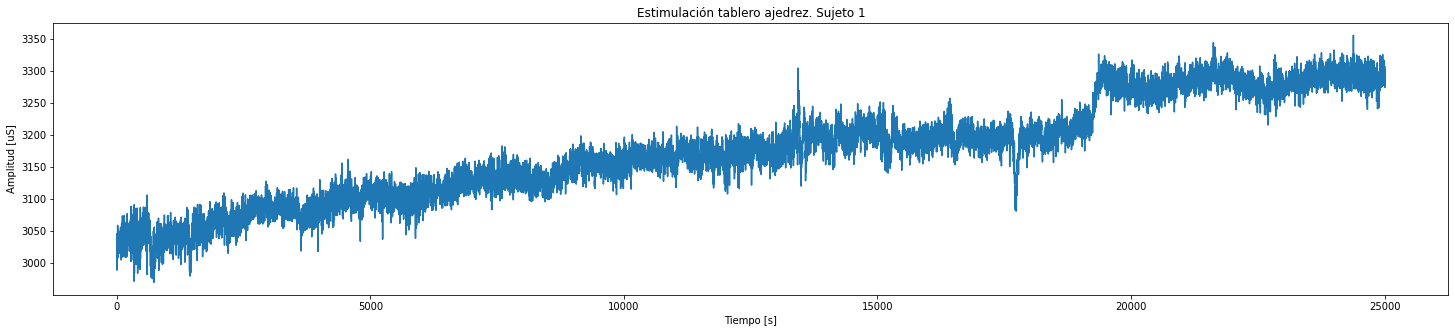

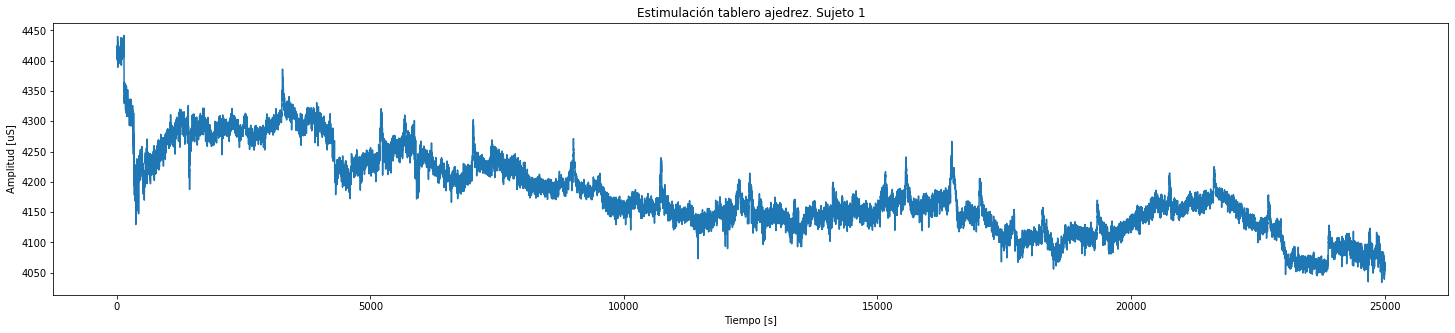

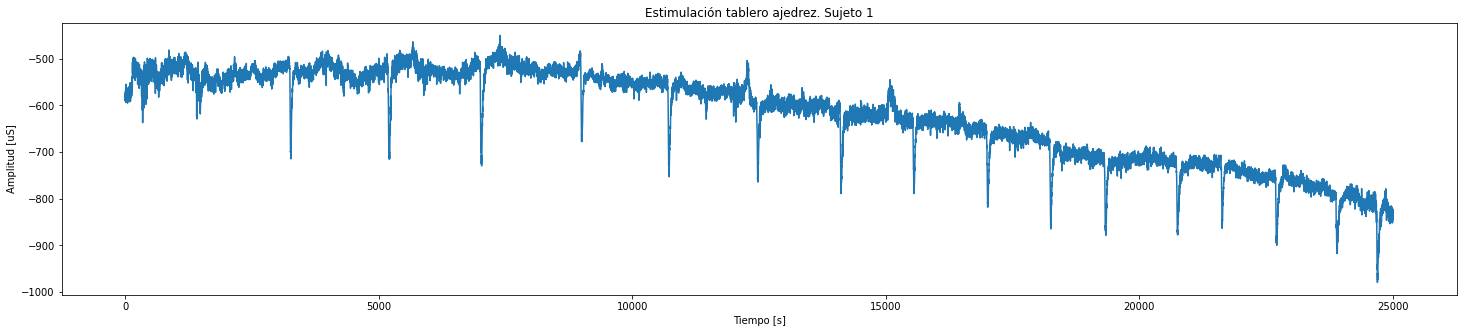

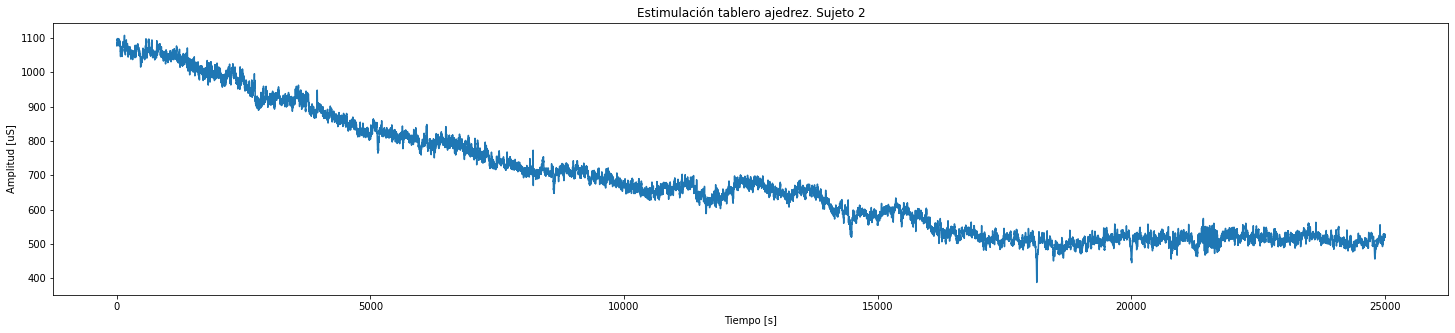

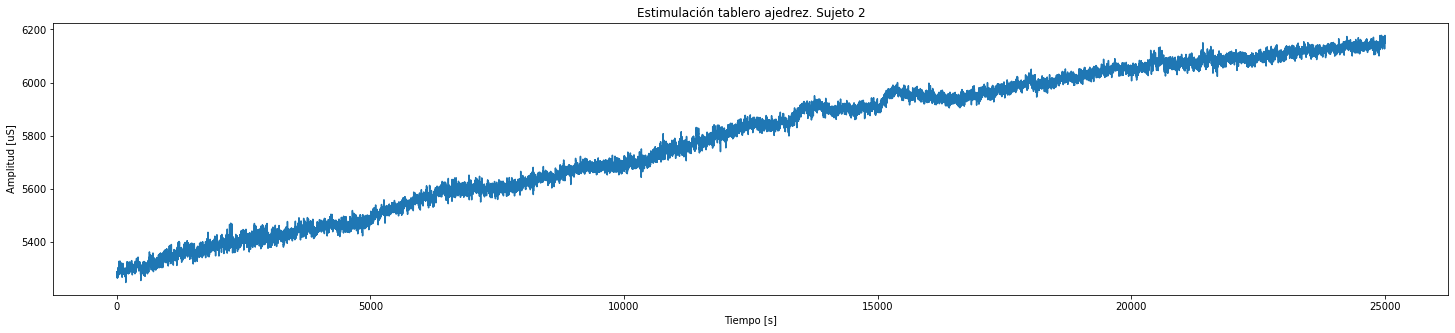

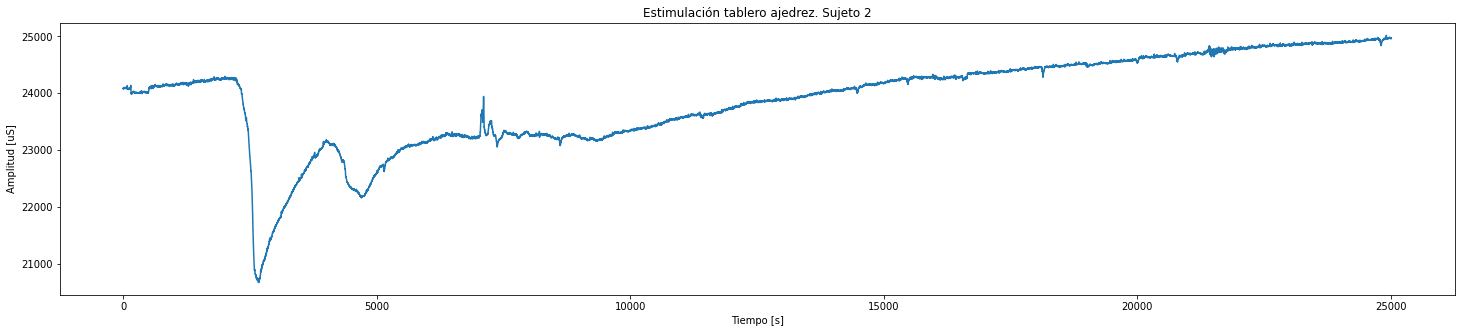

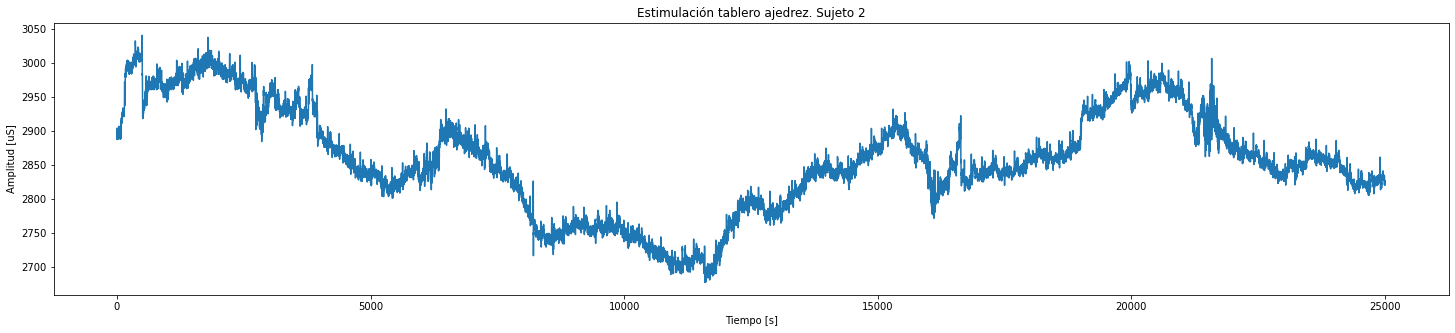

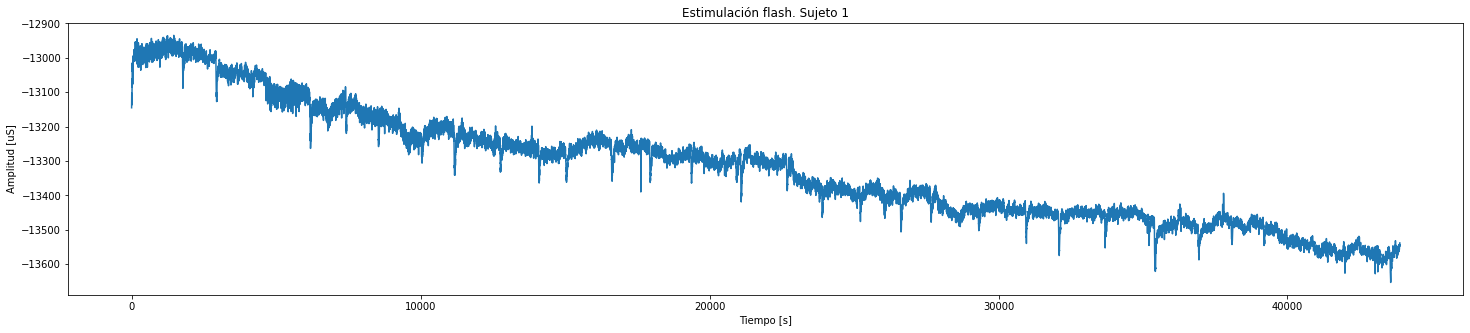

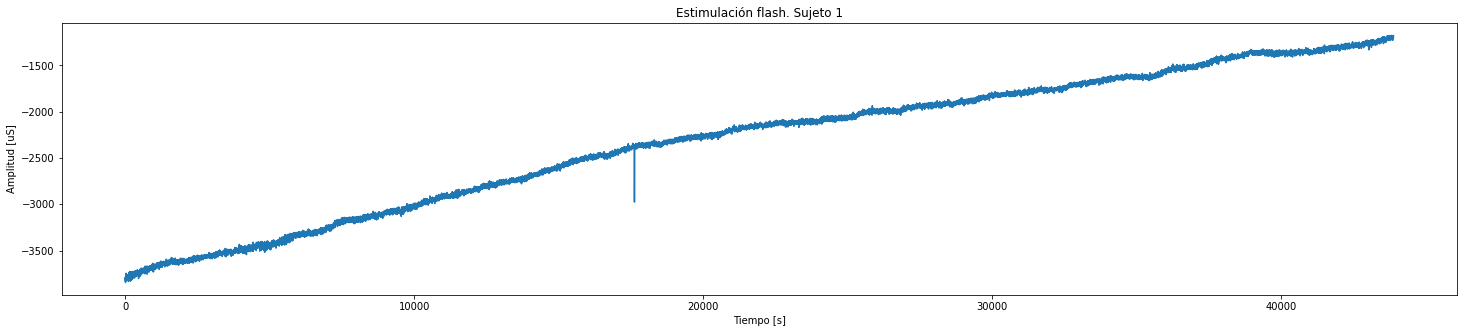

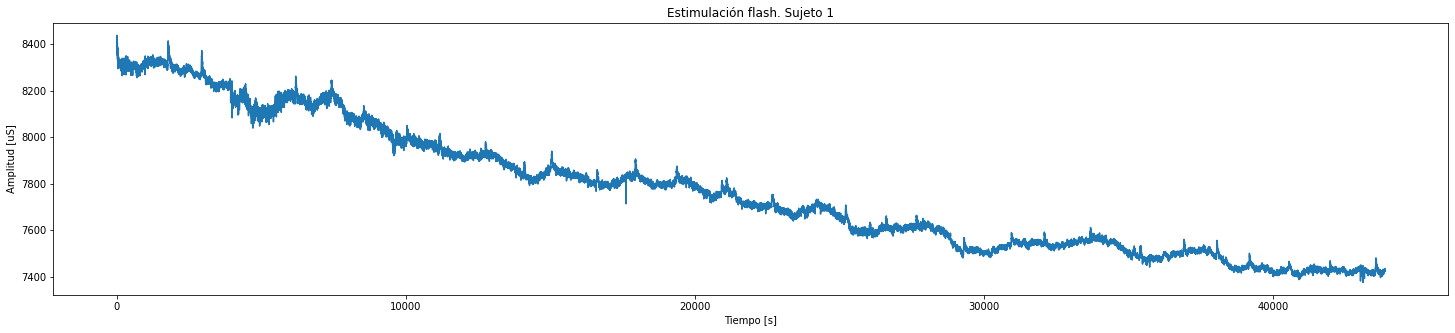

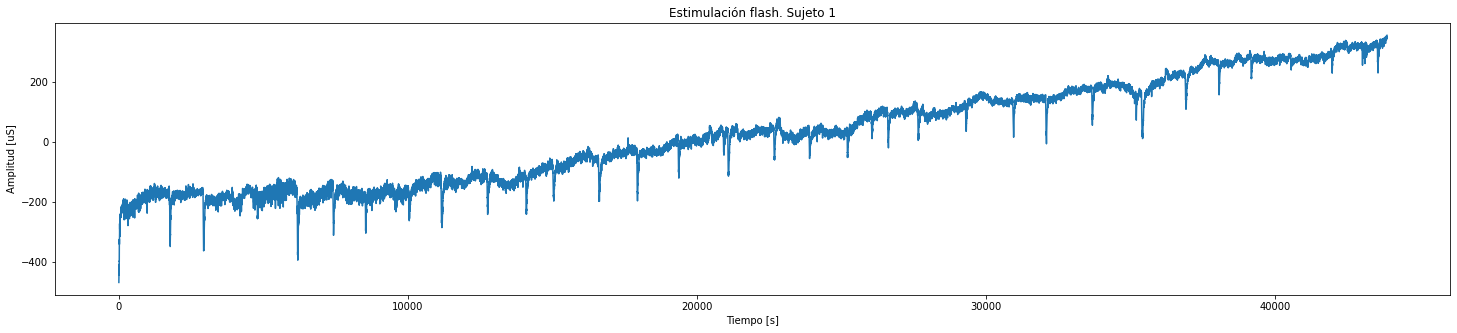

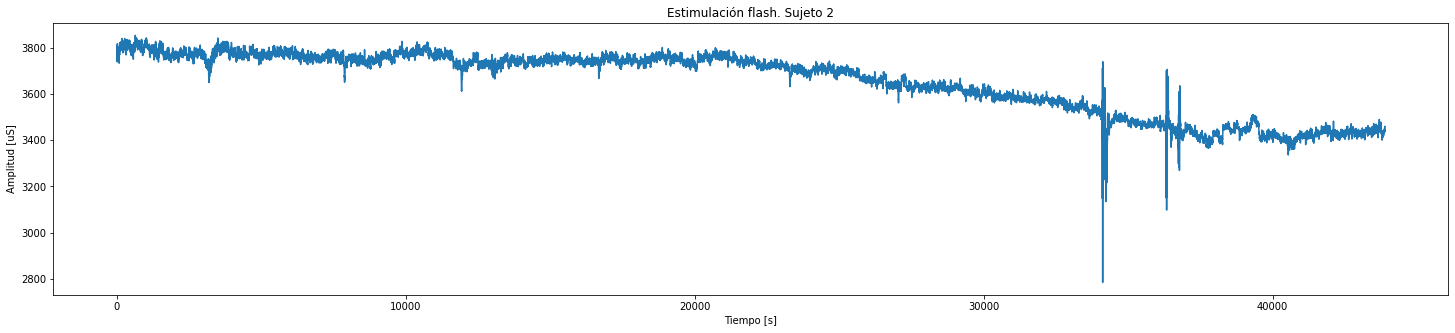

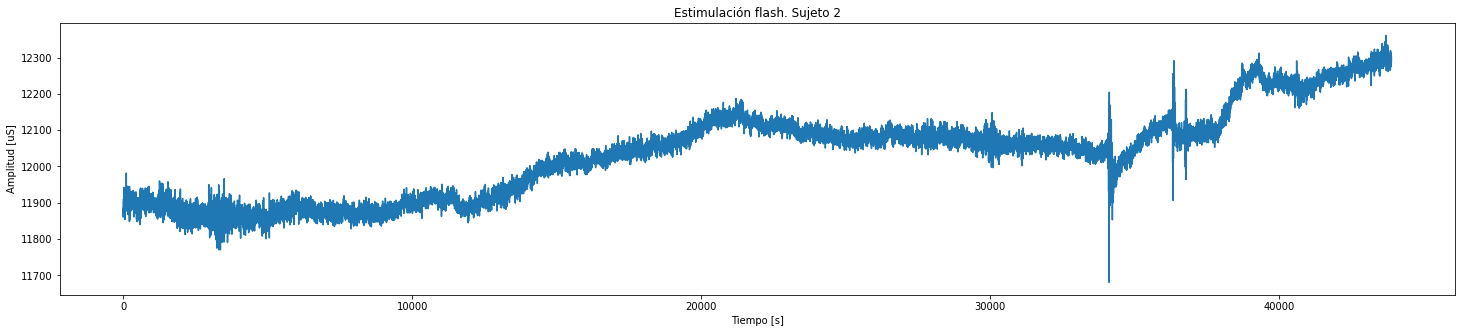

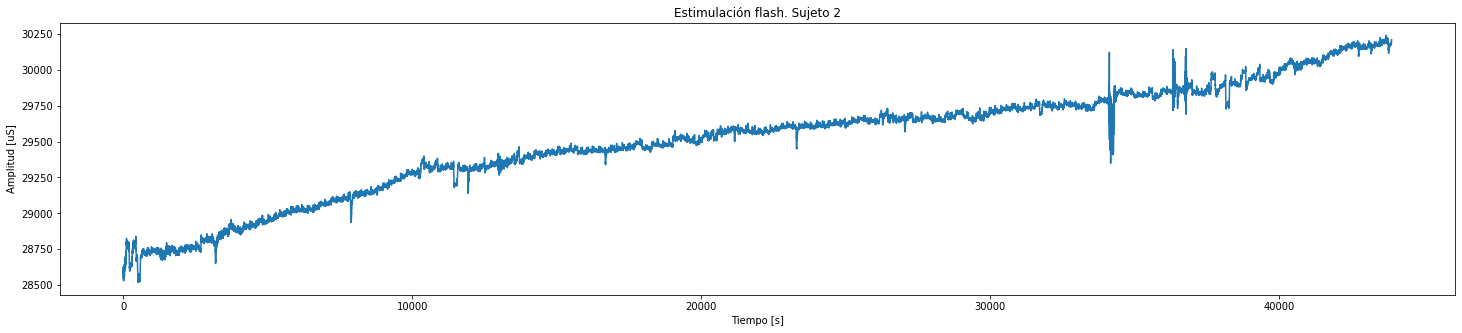

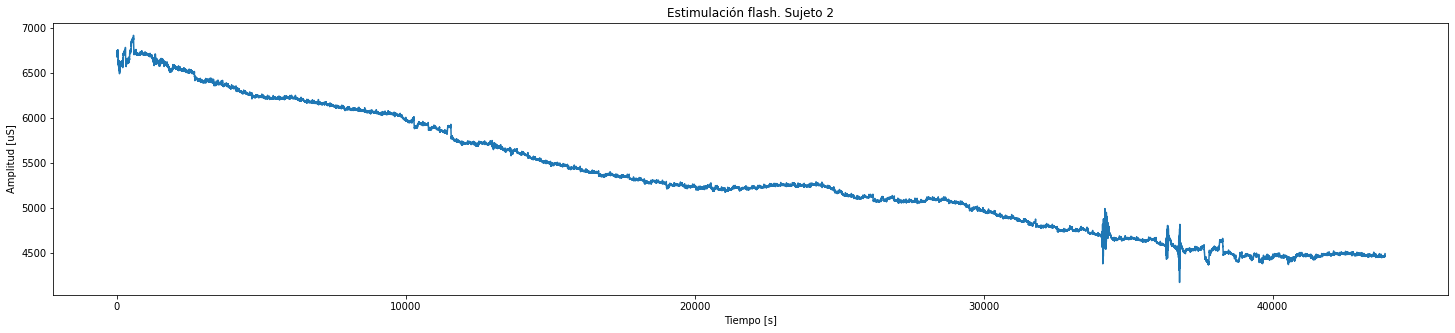

In [ ]:
graficar_canales(dic_A1,'Estimulación tablero ajedrez. Sujeto 1')
graficar_canales(dic_A2,'Estimulación tablero ajedrez. Sujeto 2')
graficar_canales(dic_F1,'Estimulación flash. Sujeto 1')
graficar_canales(dic_F2,'Estimulación flash. Sujeto 2')

##Acondicionamiento de las señales
---

###Eliminar ruido de alta frecuencia
----

Se considera ruido de alta frecuencia a aquel ruido con frecuencia mayor a 100Hz, sin embargo dado que la señal de EEG de superficie tiene frecuencias de interés hasta 30Hz, se decide eliminar el ruido de alta frecuencia usando un filtro pasa-bajos con frecuencia de corte de 30Hz, eliminando cualquier ruido con frecuencia mayor.

In [ ]:
dic_A1_F={}
dic_A2_F={}
dic_F1_F={}
dic_F2_F={}

def filtro_pasabajos(diccionario,dic_guardar,L=2**5,fc=30,fs=250):
  claves=list(diccionario.keys())
  hp=butter(L,fc,output='sos',btype='low',fs=fs)

  for i in range(len(claves)):
    dic_guardar[claves[i]]=sosfiltfilt(hp,diccionario[claves[i]])

In [ ]:
filtro_pasabajos(dic_A1,dic_A1_F)
filtro_pasabajos(dic_A2,dic_A2_F)
filtro_pasabajos(dic_F1,dic_F1_F)
filtro_pasabajos(dic_F1,dic_F2_F)

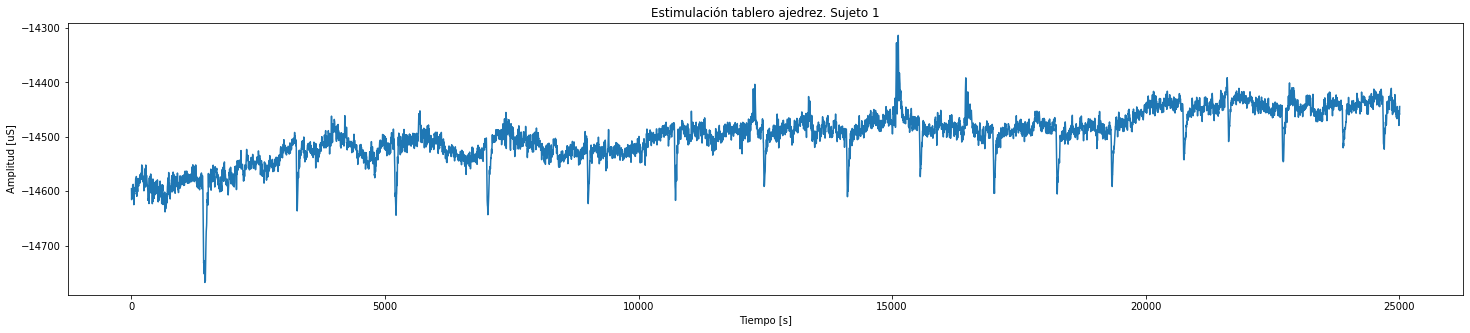

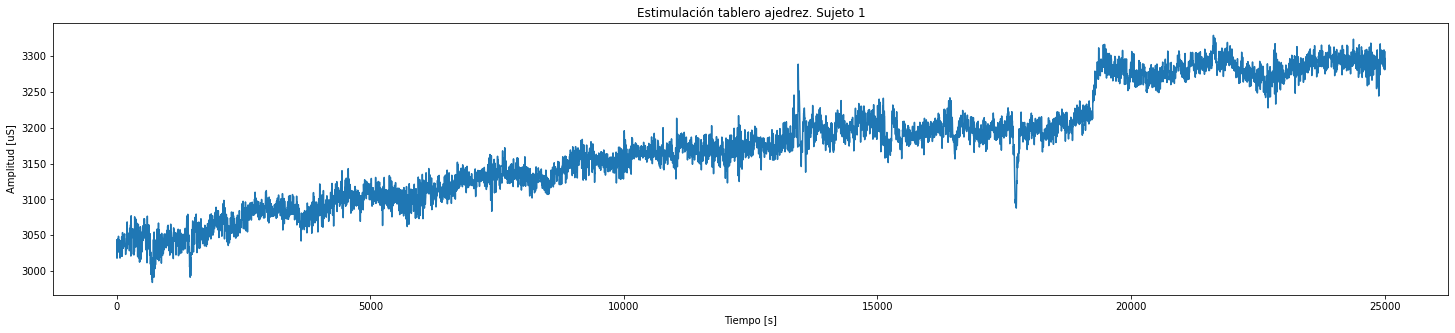

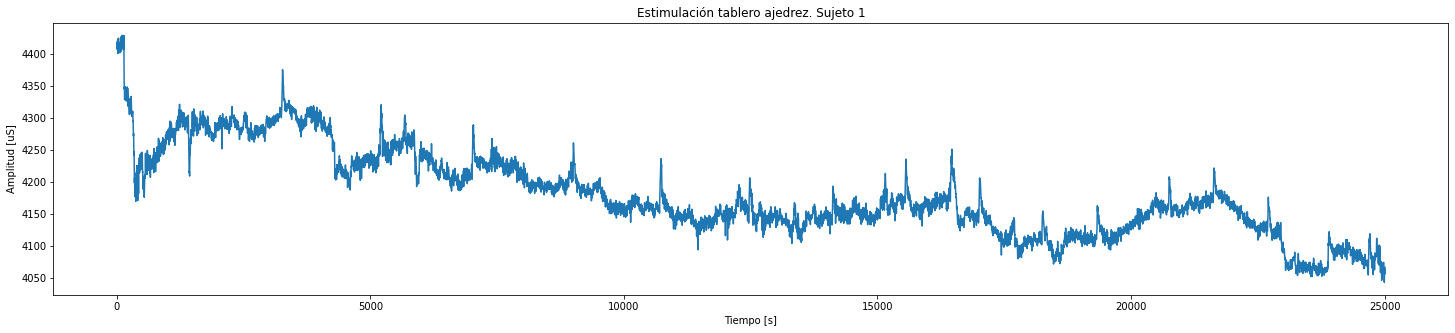

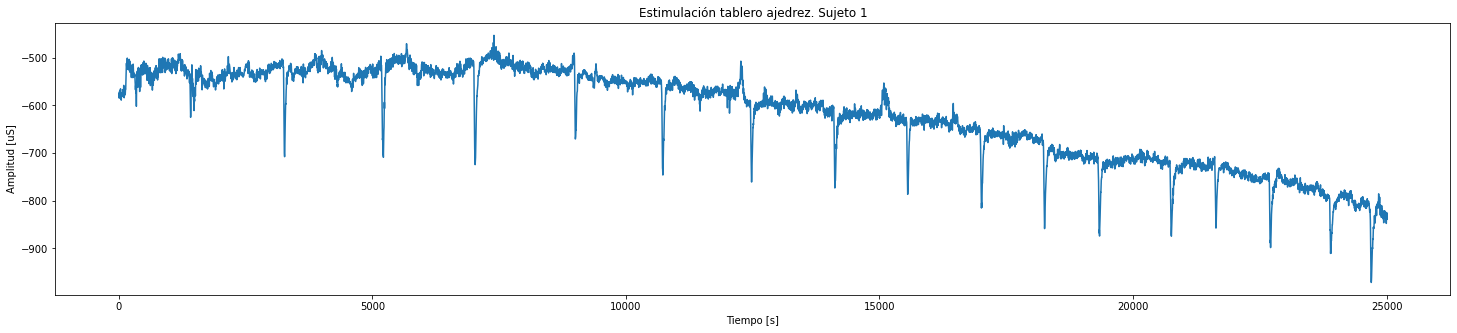

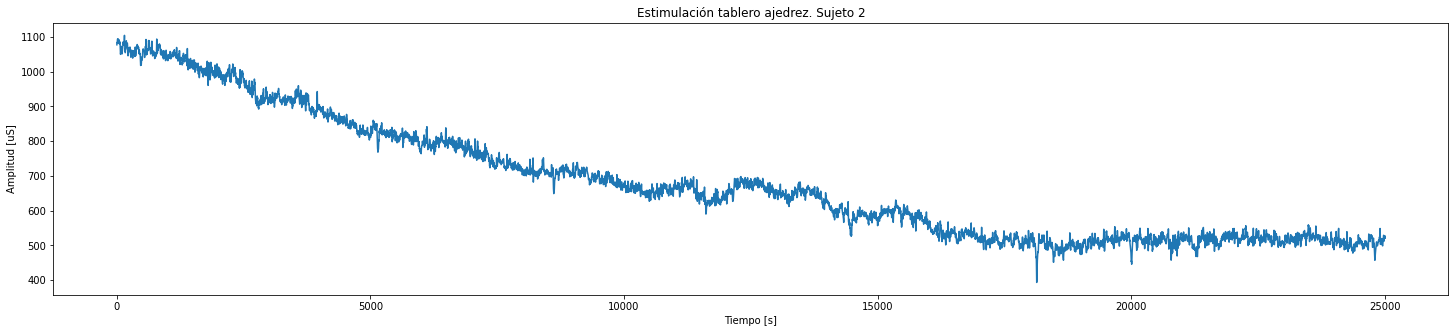

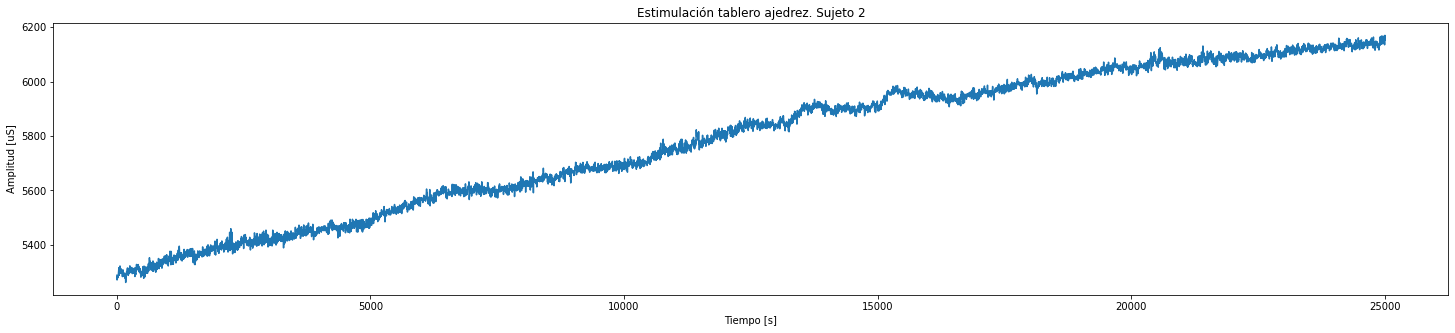

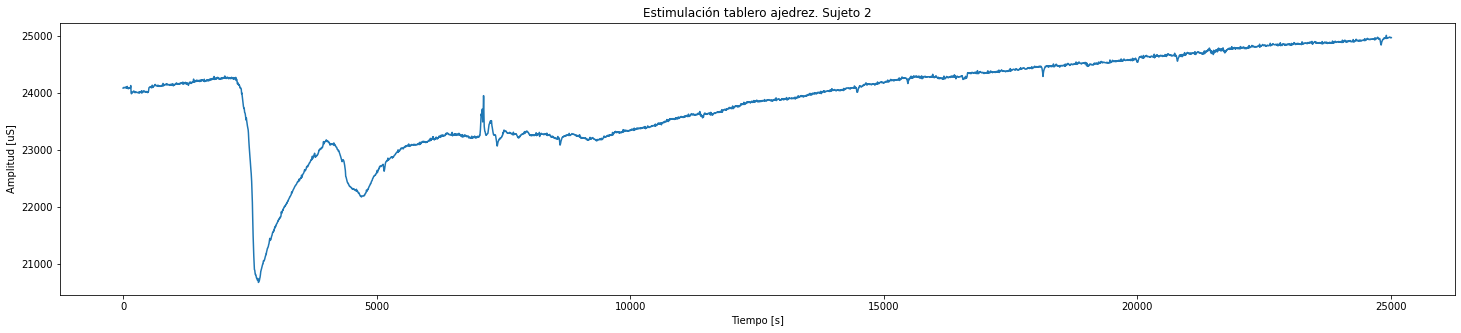

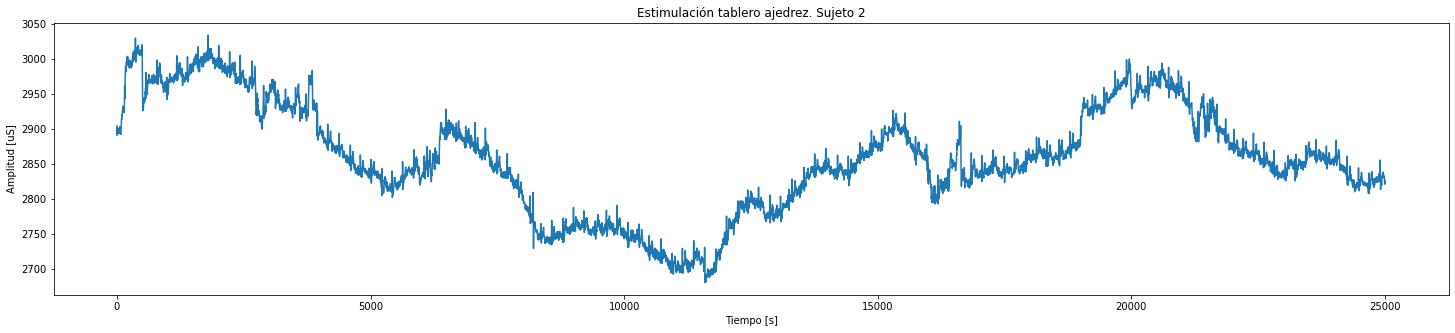

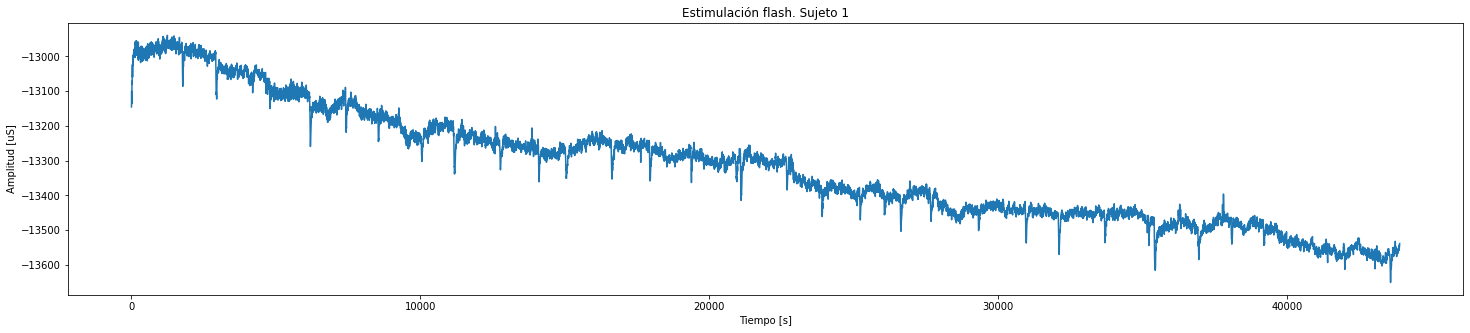

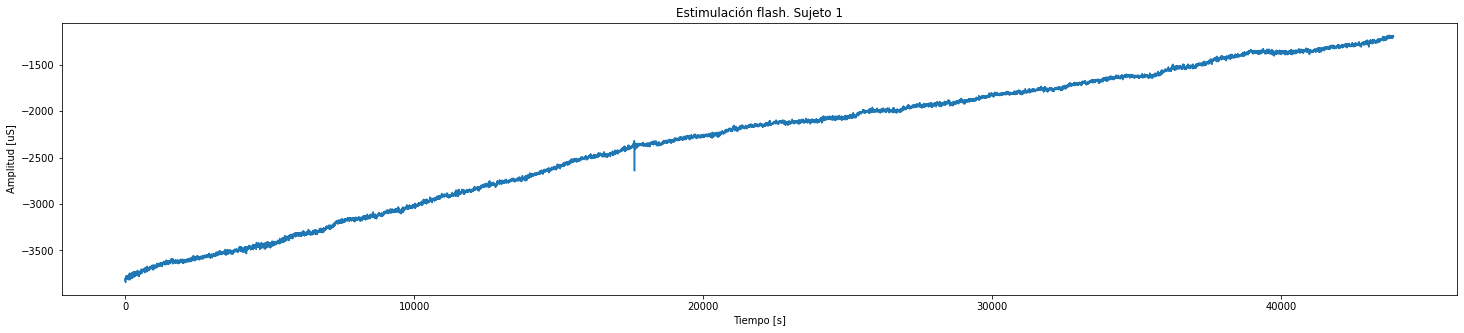

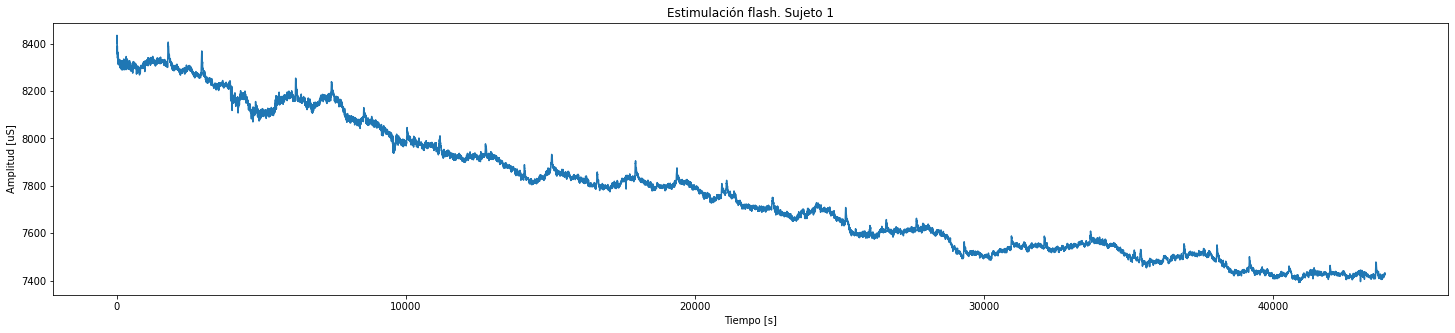

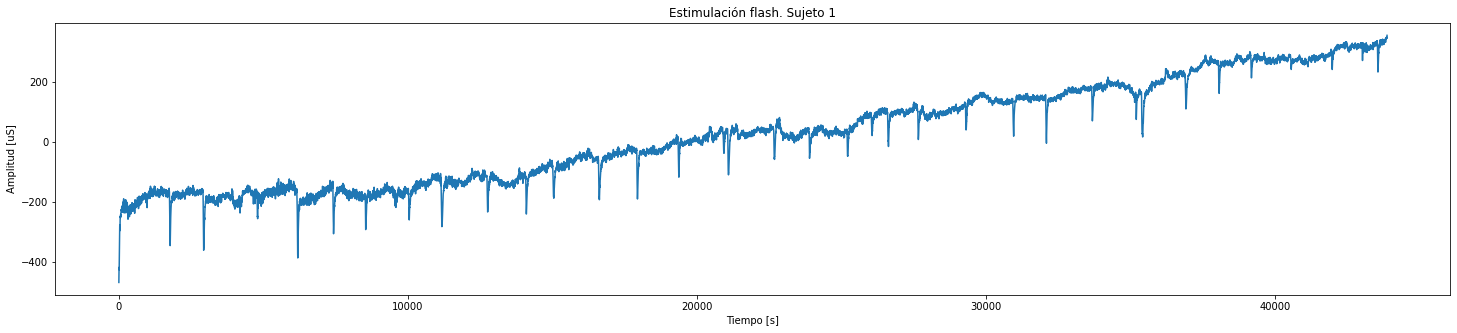

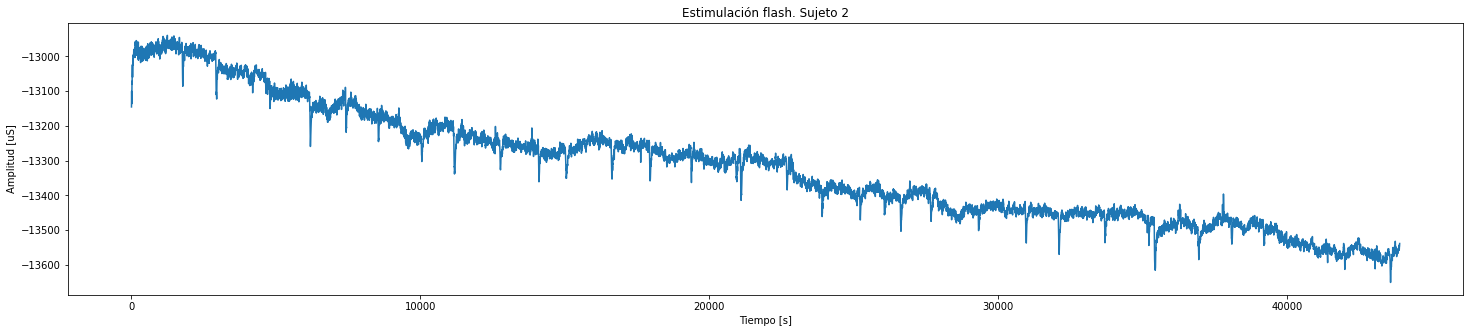

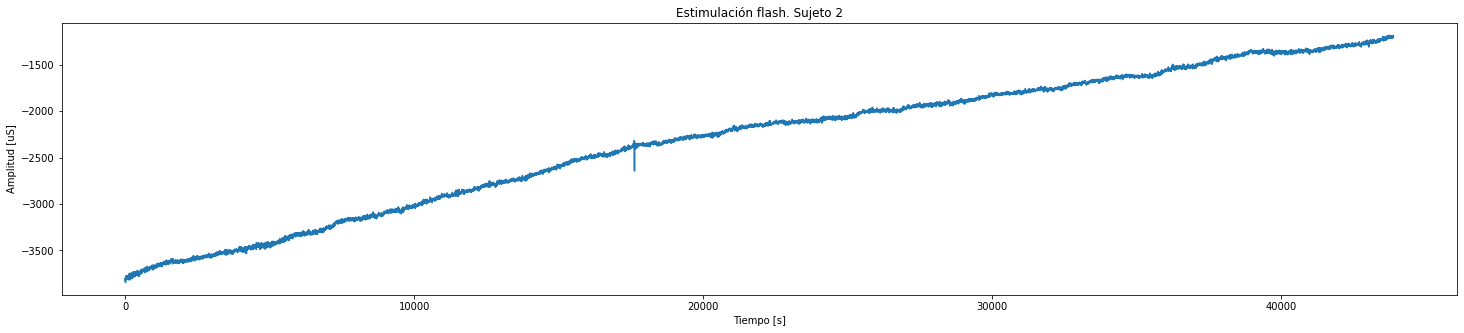

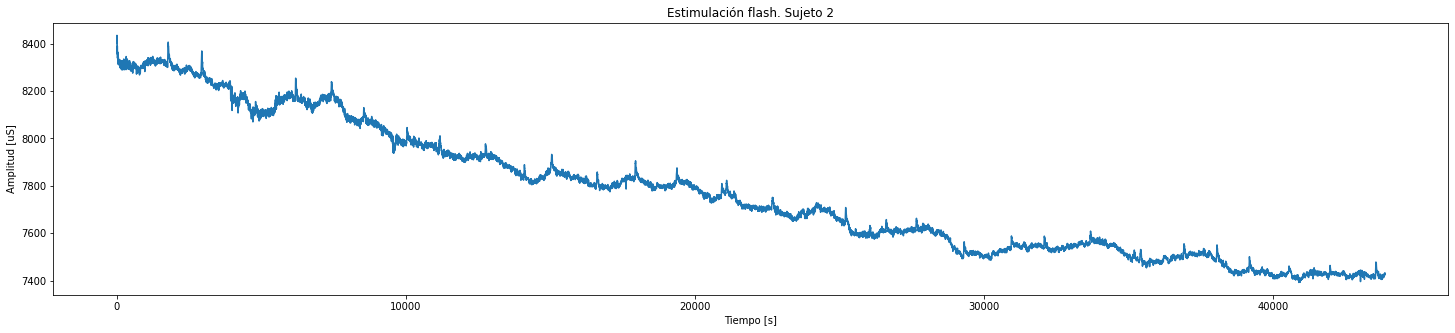

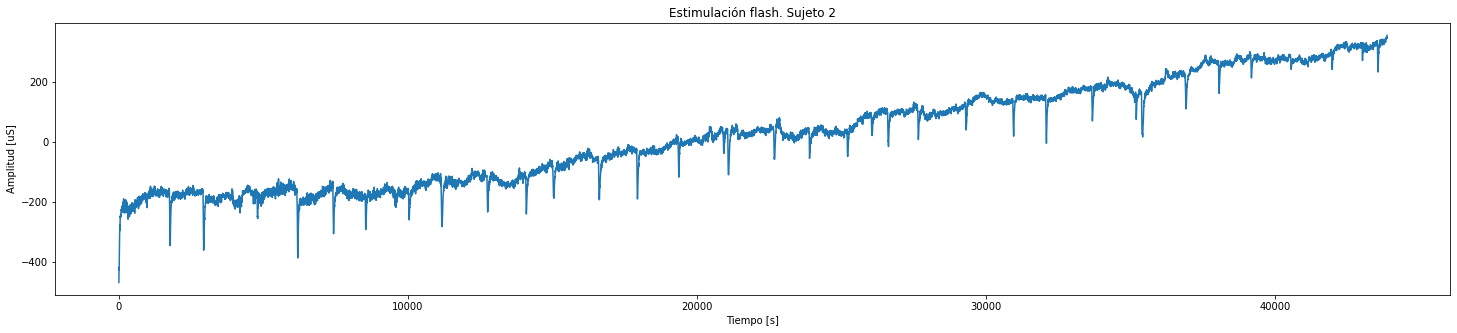

In [ ]:
graficar_canales(dic_A1_F,'Estimulación tablero ajedrez. Sujeto 1. Sin ruido de alta frecuencia')
graficar_canales(dic_A2_F,'Estimulación tablero ajedrez. Sujeto 2. Sin ruido de alta frecuencia')
graficar_canales(dic_F1_F,'Estimulación flash. Sujeto 1. Sin ruido de alta frecuencia')
graficar_canales(dic_F2_F,'Estimulación flash. Sujeto 2. Sin ruido de alta frecuencia')

###Eliminar ruido deriva
----

El ruido deriva se debe a cambios lentos, lo que hace que la señal a lo largo del tiempo aumente o disminuya su amplitud con cierta tendencia. Por esto para eliminarlo se le aplica a la señal un filtro pasa-altos con frecuencia de corte 0.5Hz, dado que el EEG de superficie tiene frecuencias de interés a partir de esta. 

In [ ]:
def filtro_pasaaltos(diccionario,L=2**5,fc=30,fs=250):
  claves=list(diccionario.keys())
  hp=butter(L,fc,output='sos',btype='high',fs=fs)

  for i in range(len(claves)):
    diccionario[claves[i]]=sosfiltfilt(hp,diccionario[claves[i]])

In [ ]:
filtro_pasaaltos(dic_A1_F)
filtro_pasaaltos(dic_A2_F)
filtro_pasaaltos(dic_F1_F)
filtro_pasaaltos(dic_F2_F)

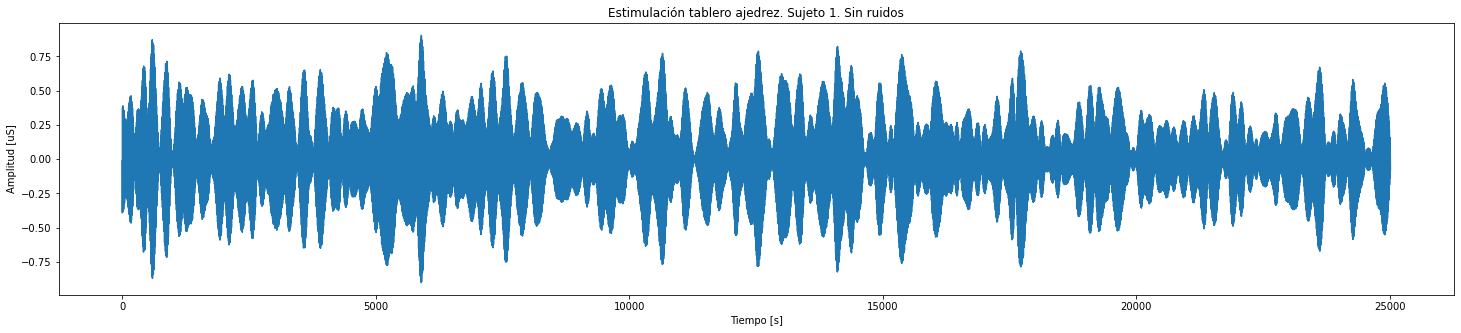

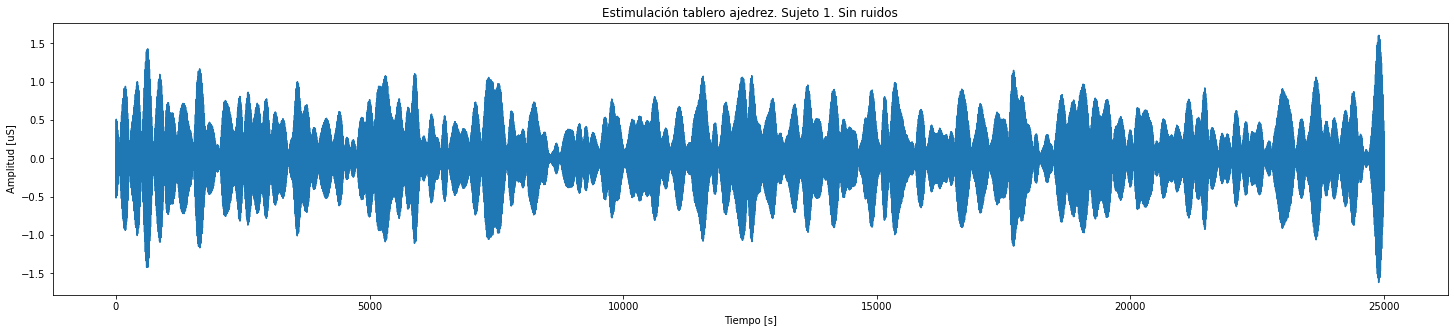

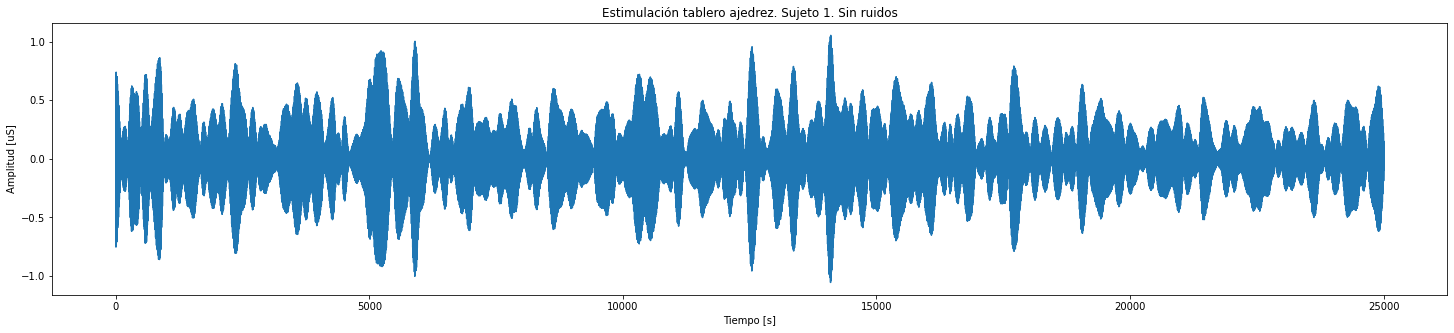

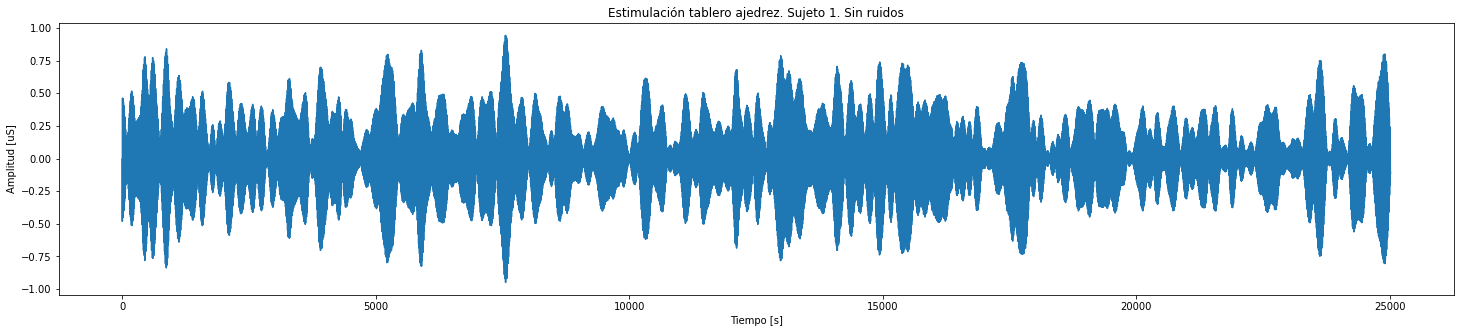

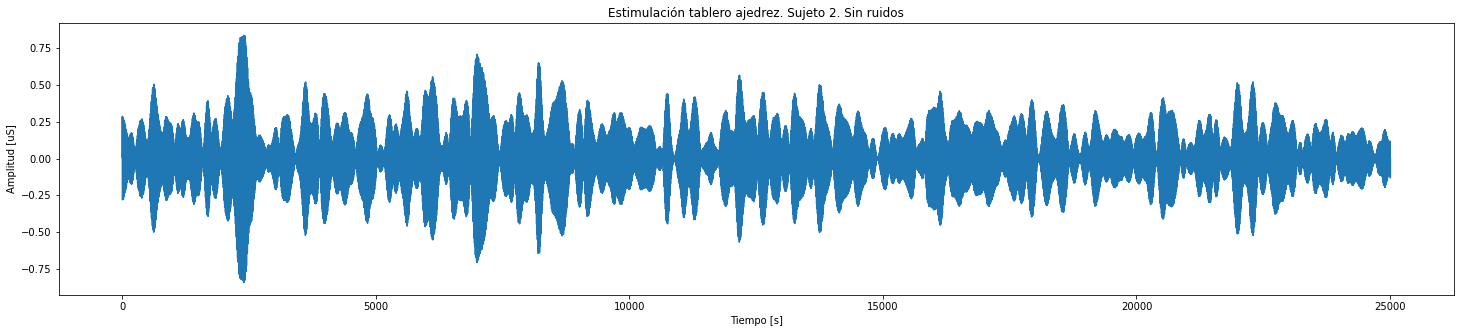

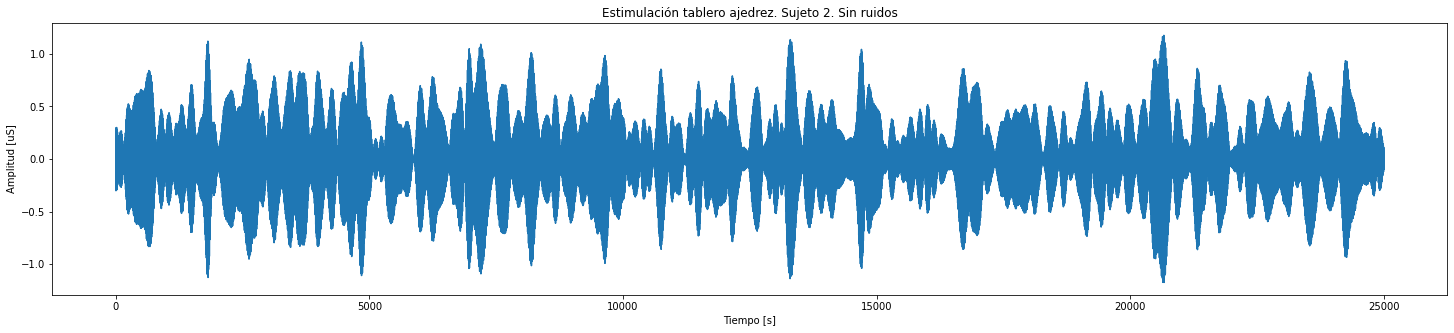

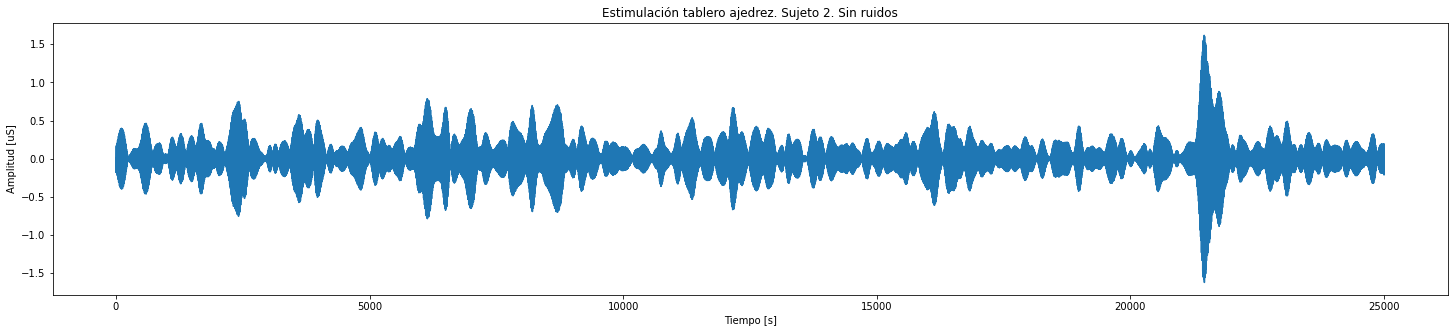

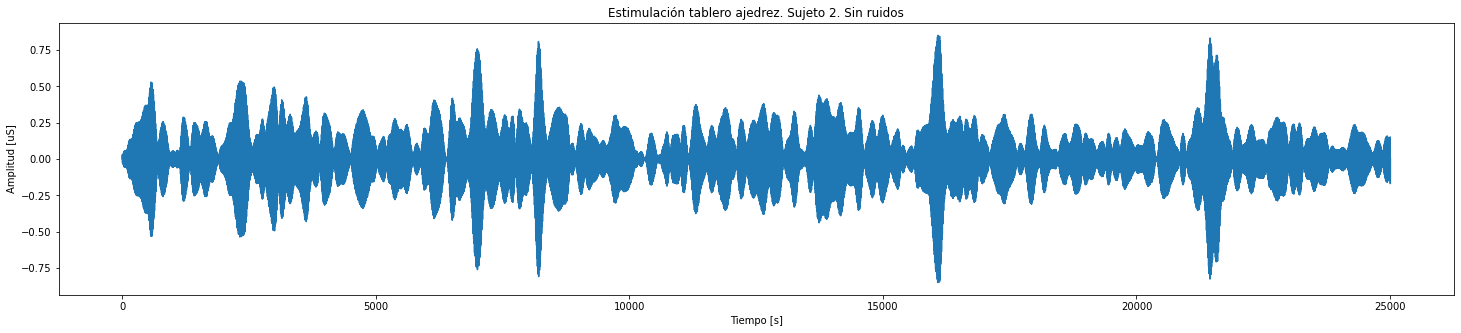

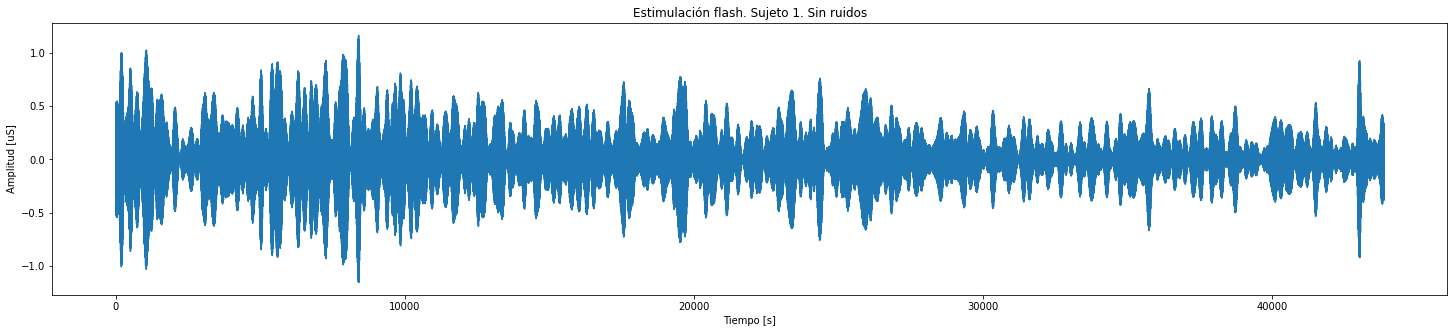

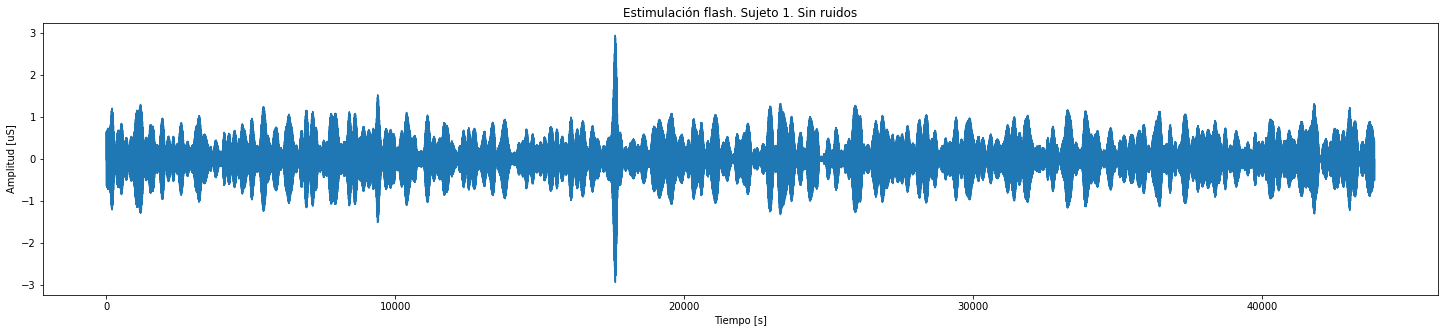

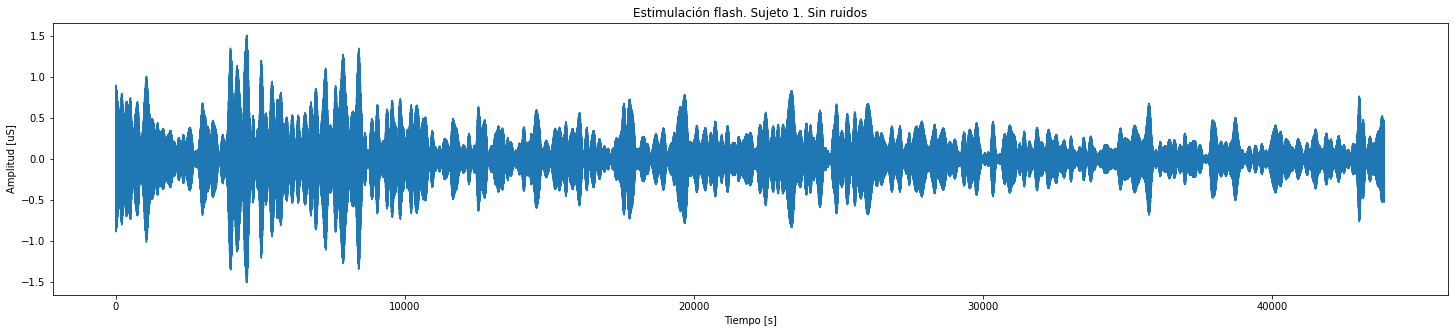

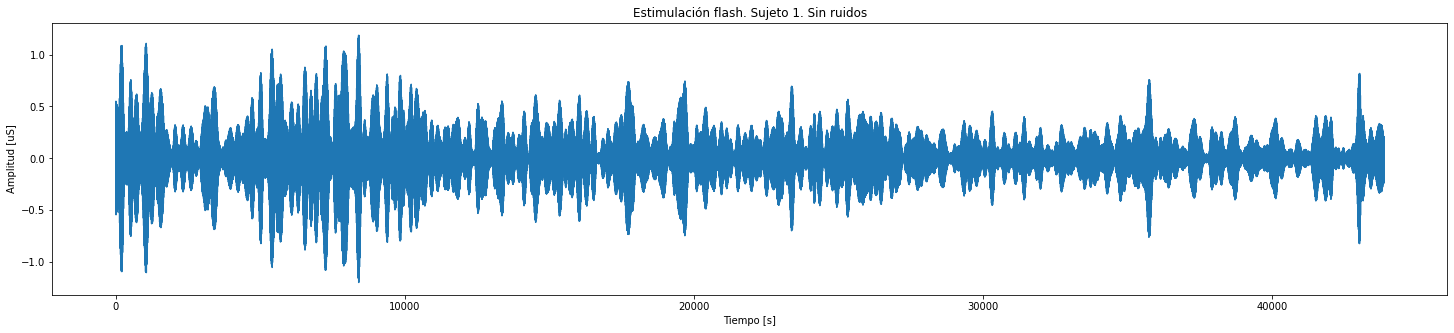

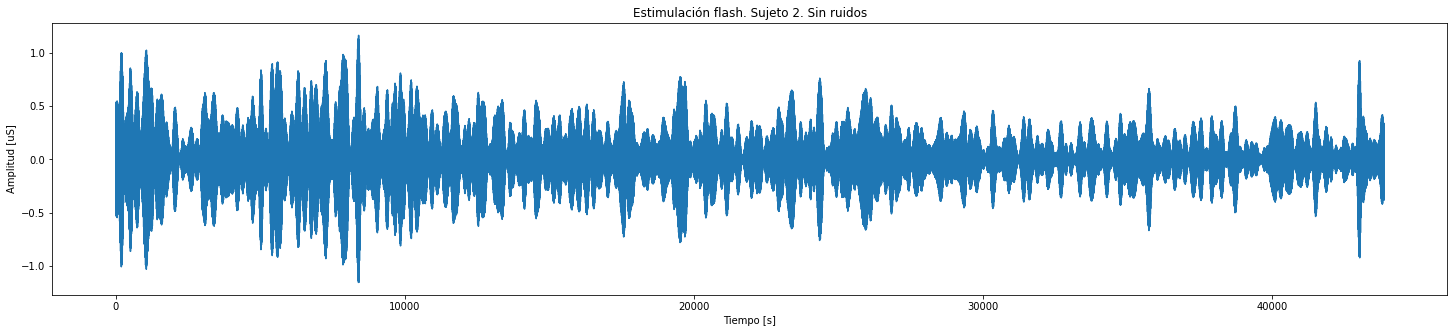

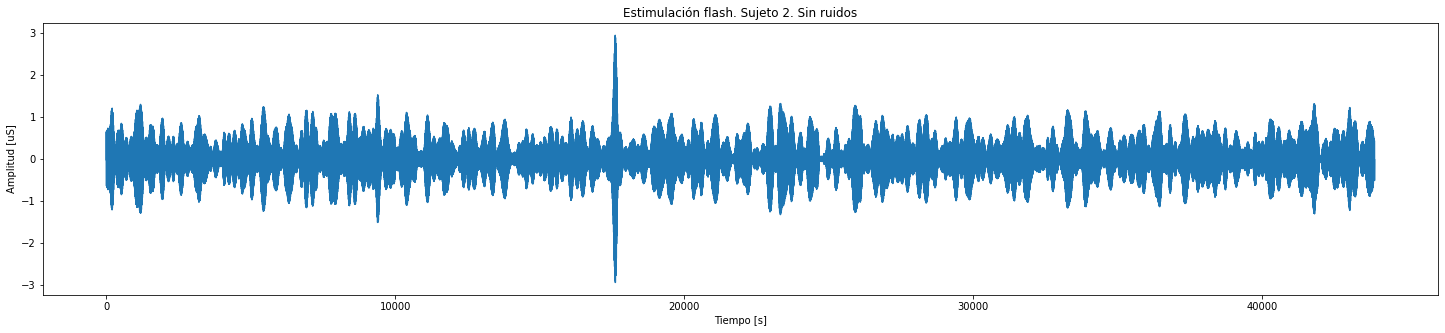

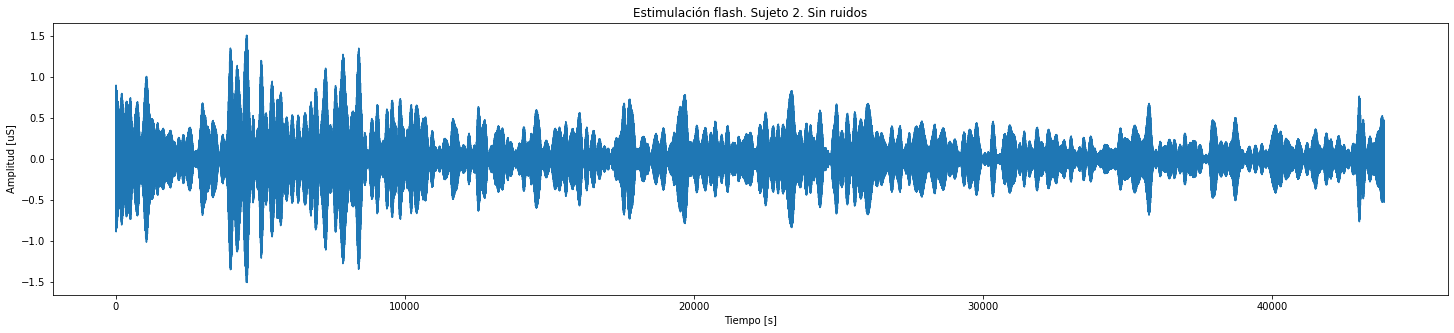

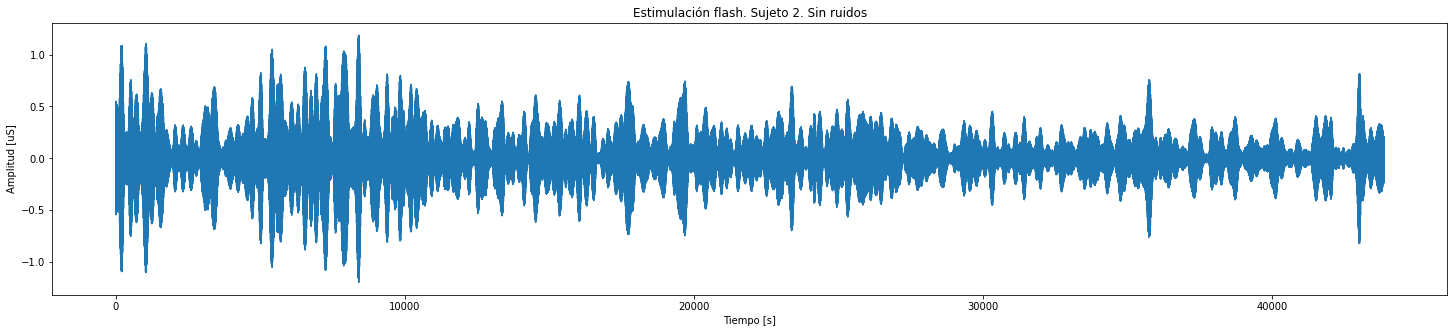

In [ ]:
graficar_canales(dic_A1_F,'Estimulación tablero ajedrez. Sujeto 1. Sin ruidos')
graficar_canales(dic_A2_F,'Estimulación tablero ajedrez. Sujeto 2. Sin ruidos')
graficar_canales(dic_F1_F,'Estimulación flash. Sujeto 1. Sin ruidos')
graficar_canales(dic_F2_F,'Estimulación flash. Sujeto 2. Sin ruidos')

###Eliminación artefactos causados por el movimiento ocular
---



Para eliminar el ruido causado por el movimiento ocular se usa el Wiener adaptativo. Dado que hay dos señales de EOG, por un lado se va a probar como queda la señal eliminando el ruido del EOG izquierdo y por otro lado eliminando el EOG derecho.

In [ ]:
def Wiener_Adaptativo(señal,ruido,L=2**8,a=0.7):

  #Parametros e inicialización 

  maximoseñal=np.max(np.abs(señal))
  señal=señal/maximoseñal
  ruido=ruido/(np.max(np.abs(ruido)))

  Px=np.mean(señal**2)
  mu=a/(10*L*Px)
  M=señal.shape[0]

  h=np.zeros([1,L])
  y=np.zeros([1,M])
  e=np.zeros([1,M])

  for i in range(L,M):
    x1=señal[i:i-L:-1]
    y[0,i]=h.dot(x1)
    e[0,i]= ruido[i]-y[0,i]
    h = h + mu * e[0,i] * x1
  
  h=h[0]

  filtrada = scipy.signal.lfilter(h, 1, señal)

  xffn=np.array(señal-filtrada)
  xff=np.array(señal-filtrada)*(maximoseñal)

  return xff

In [ ]:
dic_A1_EOG={}
dic_A2_EOG={}
dic_F1_EOG={}
dic_F2_EOG={}

def guardar_eog(guardar,señal):

  guardar['Fz izq']=Wiener_Adaptativo(señal['Fz'],señal['EOGi'])
  guardar['Oz izq']=Wiener_Adaptativo(señal['Oz'],señal['EOGi'])
  guardar['Fz der']=Wiener_Adaptativo(señal['Fz'],señal['EOGd'])
  guardar['Oz der']=Wiener_Adaptativo(señal['Oz'],señal['EOGd'])

guardar_eog(dic_A1_EOG,dic_A1_F)
guardar_eog(dic_A2_EOG,dic_A2_F)
guardar_eog(dic_F1_EOG,dic_F1_F)
guardar_eog(dic_F2_EOG,dic_F2_F)

A continuación se grafica por un lado la señal filtrada con el EOG izquierdo vs la original, y por otro la señal filtrada con el EOG derecho vs la original.

In [ ]:
def grafico_EOG(señal,filtradas):
  t=np.linspace(0,len(diccionario[claves[0]])/250,len(diccionario[claves[0]]))
  plt.figure(figsize=)

###Gráficos
---------

Para ver como quedaron las señales al eliminarles los diferentes ruidos se grafican

In [1]:
for i in range(len(claves)):
  plt.figure(figsize=(25,3))
  plt.plot(dic_EEG_HP[claves[i]])
  plt.xlabel('Muestras')
  plt.ylabel('Amplitud [uV]')
  plt.title(claves[i])
  plt.show()
  

NameError: ignored